# Introduction to NLP Fundematals in TensorFlow
NLP has the goal of deriving information out of natural language(could be sequences text or speech)
Another common term for NLP problems is sequence to squence problems(seq2seq)

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f591927a-95bf-ae18-8f19-b1c0964a45e2)
GPU 1: Tesla T4 (UUID: GPU-87f9ba5c-4320-68f7-7dc1-fbdde3b7fa11)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-11-04 09:48:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-04 09:48:47 (89.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback,unzip_data,plot_loss_curves,compare_historys

2025-11-04 09:48:50.561837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762249731.035558      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762249731.174589      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Get a text dataset
the dataset we're going to be using is Kaggle's introduction to NLP dataset(text samples of tweets labelled as diaster or not diaster).

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2025-11-04 09:49:08--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.64.207, 192.178.129.207, 142.251.184.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.64.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2025-11-04 09:49:08 (92.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
# unzip the data
unzip_data("nlp_getting_started.zip")

In [6]:
import tensorflow as tf
import pandas as pd


In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1,random_state=42)

In [10]:
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
# what does the tesst dataframe look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
# how many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [13]:
len(train_df),len(test_df)

(7613, 3263)

In [14]:
# Let's visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _,text,target = row 
    print(f"target: {target}","(real diaster)" if target > 0 else "(not real diaster)" )
    print(f"Text:\n{text}\n")
    print(10*"__","\n")

target: 1 (real diaster)
Text:
In Europe nature is kind while in US they have tornados hurricanes wild fires earthquakes flash floods mega snow droughts.

____________________ 

target: 0 (not real diaster)
Text:
(Also I dont think sewing thought a leather belt would work out that well lol)

____________________ 

target: 0 (not real diaster)
Text:
[Question] Is anybody else having this problem with the '7' circle in Epicentre? via /r/jailbreak http://t.co/48TPnmbJVG

____________________ 

target: 0 (not real diaster)
Text:
@God how come bugs haven't all drowned out of existence every time it rains?

____________________ 

target: 0 (not real diaster)
Text:
self harm// I'm so angry please tag your scars on tumblr jesus christ i dont wanna get triggered

____________________ 



### Split data into training and validation datasets

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                           test_size=0.1,
                                                                           random_state=42)

In [17]:
len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [18]:
# check the first ten samples
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into number, machine learning don't know text.
when dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.
There are a few ways to do this, namely:
* *Tokenization* - direct mapping of token (a token could be a word, a character or in between) to number.
* *Embedding* - Create a matrix of feature vector for each token ( the size of the feature vector can be defined and this embedding can be learned)

### Text vecorization(tokenization)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [20]:
text_vectorizer = TextVectorization(max_tokens=None, # how many word in the vocablary (automatically add <OOV>
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map token to number
                                    output_sequence_length=None ,# how long do you want your sequence to be
                                    )

I0000 00:00:1762249750.682551      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762249750.683257      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [21]:
# find the average number of tokens(words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]))/len(train_sentences)

14.901036345059115

In [22]:
# setup  text vectorization variables
max_vocab_length =10000 # max number of words to have in our vocablary
max_length = 15 # max lenght our sequences will be ( e.g how many words from a tweet does a model see?)


In [23]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length
                                   )

In [24]:
# Fit the text vectorizer to the training sentence
text_vectorizer.adapt(train_sentences)

In [25]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [26]:
# Choose a random sentece from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence} \n\nVectorized Version: {text_vectorizer(random_sentence)} ")
text_vectorizer(random_sentence)

Original text:
 http://t.co/QGyN2u1UP3 Rescued Med migrants arrive in Sicily: Hundreds of migrants rescuedÛ_ http://t.co/wiS3H9Tqrm 

Vectorized Version: [   1  388 1124  330 2191    4 1982  482    6  330 9165    1    0    0
    0] 


<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   1,  388, 1124,  330, 2191,    4, 1982,  482,    6,  330, 9165,
          1,    0,    0,    0])>

In [27]:
# check if token is a sentence have the same int value across different sentences
sample_sentence_two = "schools are the best Western in Lit lit litterally.. LiTTErALLy.."
text_vectorizer(sample_sentence_two)

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([2718,   22,    2,  149, 1102,    4, 5214, 5214,    1,    1,    0,
          0,    0,    0,    0])>

In [28]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in vocabulary
top_5_words = words_in_vocab[:5] # get the most common word
bottom_5_words = words_in_vocab[-5:] # get the least common word
top_5_words,bottom_5_words,len(words_in_vocab)

(['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'],
 10000)

### Creating and Embedding using an Embedding Layer
To make our embedding, we going to use tensorflow embedding layer
The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector,for example, a value of 100 would mean each token gets represented by a vector 100 long
*  `input_length` = length of the sequences being passed to the embedding layer

In [29]:
 from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,
                            output_dim=128,
                             input_length=max_length
                            )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"original text: \n{random_sentence} ")
random_sentence_vectorized = text_vectorizer(random_sentence)
sample_embed = embedding(random_sentence_vectorized)
random_sentence_vectorized,sample_embed

original text: 
Molecularly targeted cancer therapy for his #LungCancer gave Rocky his life back. http://t.co/TwI3pYm7Us http://t.co/qT8JMD9pI1 


(<tf.Tensor: shape=(15,), dtype=int64, numpy=
 array([   1, 4468, 1543, 3339,   10,   79,    1,  949, 1260,   79,  129,
          88,    1,    1,    0])>,
 <tf.Tensor: shape=(15, 128), dtype=float32, numpy=
 array([[-0.02304242,  0.00508111,  0.01283804, ...,  0.01513535,
          0.04682734, -0.02316313],
        [-0.00619359, -0.00949905,  0.03926821, ...,  0.03773587,
          0.01759393,  0.0293451 ],
        [-0.01173674,  0.04183904,  0.02424357, ...,  0.01966294,
         -0.04172803,  0.03384141],
        ...,
        [-0.02304242,  0.00508111,  0.01283804, ...,  0.01513535,
          0.04682734, -0.02316313],
        [-0.02304242,  0.00508111,  0.01283804, ...,  0.01513535,
          0.04682734, -0.02316313],
        [-0.02533475, -0.00420868,  0.04432697, ..., -0.02732954,
          0.01943209,  0.00972617]], dtype=float32)>)

In [31]:
# check out a single token's embedding
sample_embed[0], sample_embed[0].shape,random_sentence_vectorized[14]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02304242,  0.00508111,  0.01283804,  0.03686682,  0.02508584,
         0.02226228,  0.00772127,  0.03103217,  0.0377243 , -0.04619084,
        -0.02697082, -0.03210689,  0.04021939, -0.02207213, -0.01208957,
        -0.01865789, -0.01680059,  0.026949  , -0.04828019,  0.00272   ,
         0.03042999,  0.02347672,  0.0069909 ,  0.02289431, -0.04018403,
         0.0207308 , -0.04816286,  0.00017074,  0.01715093,  0.03393498,
        -0.00832341,  0.02578812,  0.04172884,  0.02274576,  0.02864001,
         0.01022468, -0.00610056, -0.01983835,  0.00303996,  0.02795747,
         0.03483777,  0.0479412 , -0.01149336, -0.03849966, -0.02408168,
         0.04764911, -0.00767986, -0.02834218,  0.01376376, -0.03768879,
        -0.04289843,  0.02249788,  0.0132047 ,  0.04905409, -0.03973902,
        -0.0279569 , -0.03322513, -0.01214826, -0.03689997, -0.03781955,
        -0.04510956, -0.01554955, -0.00103829,  0.00065125, -0.01972985,
  

## Modeling a text dataset (running a series of experiment)
Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.
we'll start with a baseline and move on from there.

* Model 0: Naive Bayes(baseline)
* Model 1: Feed-Forwared neural Network(dense Model)
* Model 2: LSTM model(RNN)
* Model 3: GRU model(RNN)
* Model 4: Bidirectional-LSTM model(RNN)
* Model 5:1D Convolutional Neural Network(CNN)
* Model 6: TensorFlow Hub pretrained Feature Extractor(using transofer learning for NLP)
* Model 7: same as model 6 with 10% of training data

  How we are going to approach all of these?

  Use the standard steps in modelling with tensorflow:
  * Create a model
  * Build a model
  * Fit a model
  * Evaluate a model
  

### Model 0: Getting a baseline 
As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiment to build on

In [32]:
# !pip install scikit-learn
import sklearn
print(sklearn.__version__)

1.2.2


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [34]:
# Create tokenization and modelling pipeline 
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), # convert words into numbers using tfidf
    ("clf",MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0_history = model_0.fit(train_sentences,train_labels)

In [35]:
model_0_history

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [36]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences,val_labels)
baseline_score

0.7926509186351706

In [37]:
print(f"Our baseline model achievs an accuracy of: {baseline_score}")
train_df.target.value_counts()

Our baseline model achievs an accuracy of: 0.7926509186351706


target
0    4342
1    3271
Name: count, dtype: int64

In [38]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:2],val_sentences[:2]

(array([1, 1]),
 array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday'],
       dtype=object))

### Creating an evaluation function for our model experiments
we could evaluate all of our model's predictions with different metrics every time,however, this will be cumbersome and could easily be fixed using function
Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Percision
* Recall
* F1-score

In [39]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true, y_preds):
    """
    Calculates model accuracy, recall, precision and f1-score
    of a binary classification model.
    """
    model_accuracy = accuracy_score(y_true, y_preds) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
        y_true, y_preds, average="weighted"
    )
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1,
    }
    return model_results


In [40]:
baseline_results = calculate_results(y_true=val_labels,y_preds=baseline_preds)

In [41]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [42]:
# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"
# Bild model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(),dtype=tf.string,name="input_layer")
x = text_vectorizer(inputs) # turn the input text into number
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D(name="globalAverage_layer")(x)
# x = layers.Flatten()(x)
outputs = layers.Dense(1,activation="sigmoid",name="output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense")

In [43]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ globalAverage_layer             │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# compile the model
model_1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [123]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                             y=train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback("model_logs","model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20251104-102941
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9671 - loss: 0.1313 - val_accuracy: 0.7756 - val_loss: 0.5785
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9751 - loss: 0.1039 - val_accuracy: 0.7651 - val_loss: 0.6119
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9745 - loss: 0.0914 - val_accuracy: 0.7664 - val_loss: 0.6444
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9787 - loss: 0.0773 - val_accuracy: 0.7717 - val_loss: 0.6878
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9769 - loss: 0.0764 - val_accuracy: 0.7638 - val_loss: 0.7164


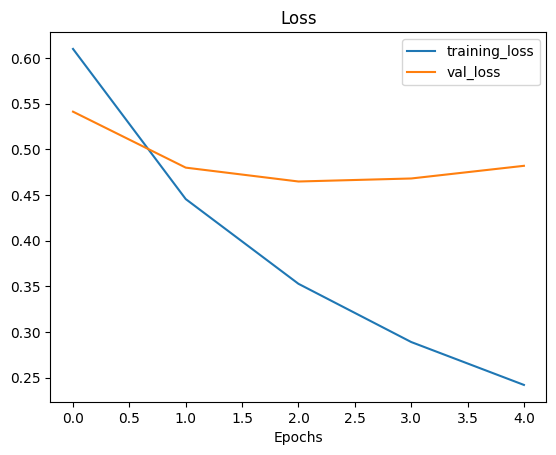

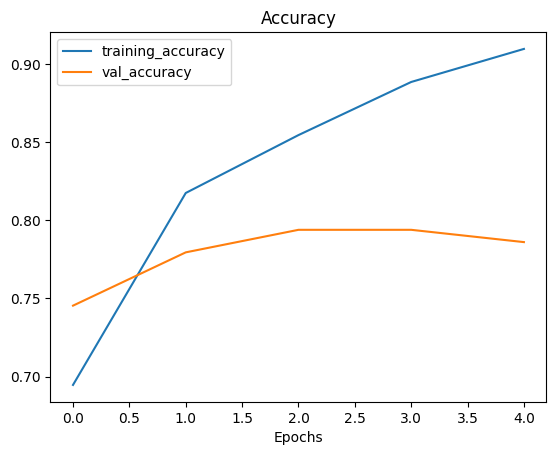

In [46]:
plot_loss_curves(model_1_history)

In [47]:
model_1.evaluate(val_sentences,val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7788 - loss: 0.5143


[0.4820229709148407, 0.7860892415046692]

In [48]:
model_1_pred_probs = model_1.predict(val_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [49]:
model_1_pred_probs.shape,val_sentences[:5],model_1_pred_probs[:5]


((762, 1),
 array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov'],
       dtype=object),
 array([[0.31795686],
        [0.61361444],
        [0.99781835],
        [0.14488369],
        [0.12340622]], dtype=float32))

In [50]:
# convert model prediction probablity to a label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [51]:
model_1_results = calculate_results(y_true=val_labels,y_preds=model_1_preds)

In [52]:
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7920916944370863,
 'recall': 0.7860892388451444,
 'f1': 0.7827032509906072}

In [53]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [54]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing Learned Embeddings

In [55]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [56]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ globalAverage_layer             │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [57]:
# get the weight metrics of embedding layer
# (these are the numberical representations of each token in our training data, which have been learned for 5 epochs)
print(f"total parameter of embedding weights: {len(embedding.get_weights()[0])}")
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights[:20])
print(f"shape of embedding: {embed_weights.shape} ")

total parameter of embedding weights: 10000
[[-3.6568675e-02 -2.0774027e-02  4.6667367e-02 ... -1.7147630e-02
   3.6845794e-03  6.1436910e-03]
 [-3.3415321e-02 -7.2209877e-03  1.9915011e-02 ...  2.5155202e-02
   3.4139957e-02 -2.9721973e-02]
 [-3.5330176e-02  5.2389298e-03  7.6538203e-03 ...  2.8134366e-02
  -2.9455073e-02 -5.2113451e-02]
 ...
 [ 6.4067706e-02 -1.0221653e-02 -2.8775152e-02 ... -4.0156534e-03
  -1.9657038e-02  6.2825657e-02]
 [-5.4059390e-02 -5.3877231e-02 -4.5408241e-02 ...  3.0517976e-03
  -5.1812440e-02  1.6293099e-02]
 [-9.1219612e-05  3.0213039e-02 -3.2493003e-02 ...  3.0728574e-03
   2.6848067e-02  4.1759465e-02]]
shape of embedding: (10000, 128) 


Now we've got the embedding matrix our mdoel has learned to represent our tokens, let's see how we can visualize it.
to do so, TensorFlow as a handy tool called projector.
and tensorflow alos has an incredible guide on word embeddings themselves.

In [58]:
words_in_vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [59]:
# Create embedding files from tensorflow word embedding docs
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [60]:
import tensorboard
print(tensorboard.__version__)

2.18.0


In [61]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/TensorBoard/model_1_dense

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)
RNN's are useful sequence data.

The promise of a recurrent neural network is to use the ***`representation`*** of a previous input to aid the representation of a later input.

### model 2: LSTM
LSTM = long short-term memory (one of the most popular LSTM cells)
OUr structure of an RNN typically looks like this:
```
Input(text) -> Tokenize -> Embedding -> Layers(RNNs/Dense) -> Output(label probability)
```

In [62]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
# print(x.shape)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64,return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_LSTM")

In [63]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model_2.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [65]:
model_2_history = model_2.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20251104-094933
Epoch 1/5


I0000 00:00:1762249775.875511     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8918 - loss: 0.2973 - val_accuracy: 0.7848 - val_loss: 0.5487
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9465 - loss: 0.1483 - val_accuracy: 0.7730 - val_loss: 0.6120
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9490 - loss: 0.1320 - val_accuracy: 0.7887 - val_loss: 0.6609
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9542 - loss: 0.1165 - val_accuracy: 0.7861 - val_loss: 0.6974
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9699 - loss: 0.0837 - val_accuracy: 0.7822 - val_loss: 0.8769


In [66]:
# make prediction with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


array([[3.6435395e-02],
       [9.0012842e-01],
       [9.9985898e-01],
       [6.7328669e-02],
       [7.1233971e-04],
       [9.9963510e-01],
       [9.5036215e-01],
       [9.9988580e-01],
       [9.9983728e-01],
       [3.4815505e-01]], dtype=float32)

In [67]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [68]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [69]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,y_preds=model_2_preds)
model_2_results

{'accuracy': 78.21522309711287,
 'precision': 0.7825699854158408,
 'recall': 0.7821522309711286,
 'f1': 0.780955868888482}

In [70]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [71]:
from math import e
print(e)
def tanh_func(z):
    a = (e**z - e**(-z))/(e**z + e**(-z)) # tensorflow don't know math and python label code durring computational graph, it must be tensorflow optrational for derivation of gradients
    return a
    # return (tf.exp(z) - tf.exp(-z)) / (tf.exp(z) + tf.exp(-z))
    # return tf.math.tanh(z)
tanh_func(1.)

2.718281828459045


0.7615941559557649

### build GRU model 3
Another popular and effective RNN component is the GRU or gated recurrent unit.
The GRU cell has similar features to an LSTM cell but has less parameters.

In [72]:
inputs = layers.Input(shape=(1,),dtype=tf.string,name="input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(units=64,activation=tanh_func)(x)
# x = layers.Lambda(tanh_func)(x)
outputs = layers.Dense(1,activation="sigmoid",name="output_layer")(x)
model_3 = tf.keras.Model(inputs,outputs)


In [73]:
model_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# compile the model
model_3.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [75]:
model_3_history = model_3.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20251104-094944
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8884 - loss: 0.2721 - val_accuracy: 0.7677 - val_loss: 0.7840
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9707 - loss: 0.0819 - val_accuracy: 0.7808 - val_loss: 0.8394
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9737 - loss: 0.0690 - val_accuracy: 0.7677 - val_loss: 0.8157
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9754 - loss: 0.0589 - val_accuracy: 0.7795 - val_loss: 0.9716
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9724 - loss: 0.0579 - val_accuracy: 0.7730 - val_loss: 1.1688


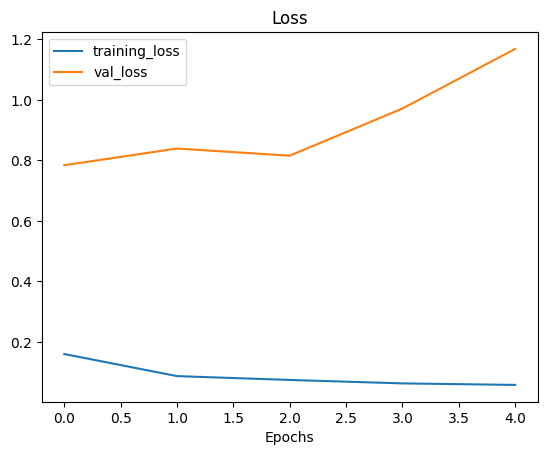

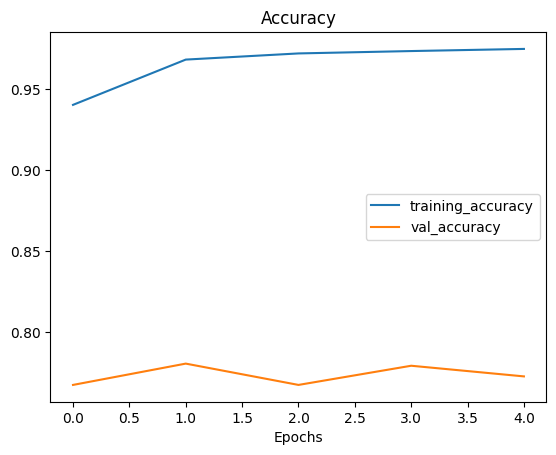

In [76]:
plot_loss_curves(model_3_history)

In [77]:
model_3_pred_probs = model_3.predict(val_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [78]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [79]:
model_3_results = calculate_results(y_true=val_labels,y_preds=model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7770640736660165,
 'recall': 0.7729658792650919,
 'f1': 0.7698502254147366}

### Model 4: Bidirectional RNN
Normal RNN go from left to right (just like you'd read and English sentence), however, a bidirectional RNN goes from right to left as well as left to right.


In [80]:
# Build a bidirectional RNN in tensorflow
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
print(x.shape)
x = embedding(x)
print(x.shape)
# x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
print(x.shape)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs)


(None, 15)
(None, 15, 128)
(None, 128)


In [81]:
model_4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model_4.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [83]:
model_4_history = model_4.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20251104-095020
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9596 - loss: 0.1835 - val_accuracy: 0.7782 - val_loss: 0.9559
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9820 - loss: 0.0457 - val_accuracy: 0.7782 - val_loss: 1.0422
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9824 - loss: 0.0404 - val_accuracy: 0.7651 - val_loss: 1.3147
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9801 - loss: 0.0471 - val_accuracy: 0.7717 - val_loss: 1.2777
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9794 - loss: 0.0453 - val_accuracy: 0.7717 - val_loss: 1.4115


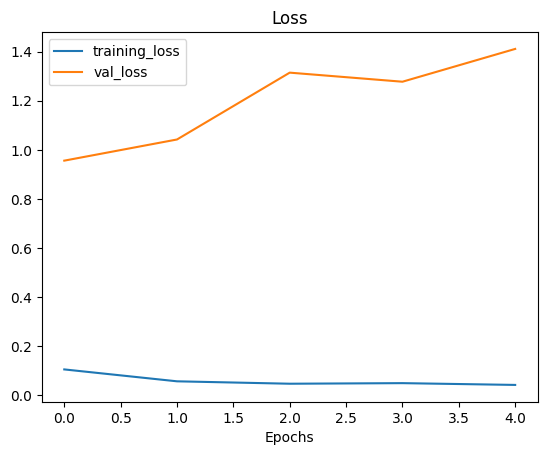

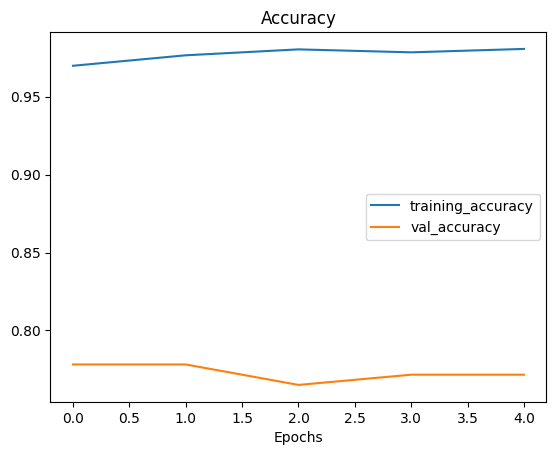

In [84]:
plot_loss_curves(model_4_history)

In [85]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


array([[2.2604056e-02],
       [8.4215295e-01],
       [9.9998868e-01],
       [1.1753368e-01],
       [2.5525293e-05],
       [9.9115342e-01],
       [9.8349400e-02],
       [9.9999082e-01],
       [9.9998617e-01],
       [5.3487515e-01]], dtype=float32)

In [86]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [87]:
model_4_results = calculate_results(y_true=val_labels,y_preds=model_4_preds)
model_4_results

{'accuracy': 77.16535433070865,
 'precision': 0.773049502603257,
 'recall': 0.7716535433070866,
 'f1': 0.7697096359746837}

## Convolutional Neural Network for Text(and other types of sequences)
We've used CNNs for images but images are typically 2D (hieght X Widht)... however, ouor text data is 1D.
Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for seqeunces (in our case,text):
```
Inputs(xtext) -> Toknization -> Embedding -> Layer(s) (typicaly Conv1D and some kind of Pooling layer) -> outputs(Class probability)
```


### Model 5: Conv1D


In [88]:
# Test out our embedding layer,Conv1D layer and max Pooling layer
vectorizer_test = text_vectorizer(["this is test sentences"])
embedding_test = embedding(vectorizer_test)
conv_1d = layers.Conv1D(filters=32,
                       kernel_size=5,
                       activation="relu",
                       padding="valid")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape,conv_1d_output.shape,max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [89]:
vectorizer_test

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  19,    9, 1246,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [90]:
voc_words = text_vectorizer.get_vocabulary()
voc_words[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [91]:
voc_words[9]

'is'

In [92]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00941995,  0.0317776 , -0.03718871, ...,  0.00702114,
          0.02007541,  0.02100018],
        [-0.05544049,  0.01238763, -0.00969902, ...,  0.03953299,
          0.03510486, -0.02466616],
        [ 0.00181401, -0.03264258,  0.07085209, ...,  0.04058366,
          0.01546346,  0.01876286],
        ...,
        [-0.0118208 ,  0.00474013,  0.02478869, ...,  0.01532344,
         -0.01114705, -0.00282948],
        [-0.0118208 ,  0.00474013,  0.02478869, ...,  0.01532344,
         -0.01114705, -0.00282948],
        [-0.0118208 ,  0.00474013,  0.02478869, ...,  0.01532344,
         -0.01114705, -0.00282948]]], dtype=float32)>

In [93]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 6.76403940e-02, 2.35186238e-02,
         5.61068468e-02, 1.84926931e-02, 0.00000000e+00, 0.00000000e+00,
         3.95284593e-02, 5.59689105e-02, 1.33662568e-02, 0.00000000e+00,
         1.41413668e-02, 8.39595031e-03, 1.03673236e-02, 7.22359419e-02,
         9.31921968e-05, 8.29964355e-02, 3.76980565e-02, 4.76688817e-02,
         5.61837032e-02, 5.98032139e-02, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.19687188e-02, 0.00000000e+00, 9.23226401e-03, 6.81847110e-02],
        [1.33200176e-02, 0.00000000e+00, 0.00000000e+00, 2.64966488e-02,
         0.00000000e+00, 2.47875620e-02, 6.10786639e-02, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 8.98724049e-03, 2.43004467e-02,
         6.33893237e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.63938757e-02, 0.00000000e+00, 1.46910632e-0

In [94]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.06197429, 0.0410183 , 0.06764039, 0.05219474, 0.05610685,
        0.02478756, 0.06107866, 0.00490324, 0.03952846, 0.05596891,
        0.03737369, 0.03019352, 0.06338932, 0.05663794, 0.01036732,
        0.07223594, 0.03640915, 0.08299644, 0.03769806, 0.04766888,
        0.13725479, 0.05980321, 0.        , 0.04554171, 0.05538018,
        0.09028454, 0.01422301, 0.06007433, 0.01196872, 0.        ,
        0.00923226, 0.06818471]], dtype=float32)>

In [95]:
# create model 5
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string,name="input_layer") # make sure you pass dtype string in input layer otherwise it treat as integer and leads to graph excution error.
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32,
                 kernel_size=5,
                 activation="relu",
                 strides=1,
                 padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid",name="output_layer")(x)
model_5 = tf.keras.Model(inputs,outputs)


In [96]:
model_5.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [98]:
# compile the model
model_5.fit(train_sentences,
               train_labels,
               epochs=5,
               validation_data=(val_sentences,val_labels),
               callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20251104-095035
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9344 - loss: 0.1982 - val_accuracy: 0.7756 - val_loss: 0.8773
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9707 - loss: 0.0796 - val_accuracy: 0.7638 - val_loss: 1.0084
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9772 - loss: 0.0646 - val_accuracy: 0.7638 - val_loss: 1.1049
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9772 - loss: 0.0536 - val_accuracy: 0.7651 - val_loss: 1.1415
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9820 - loss: 0.0443 - val_accuracy: 0.7585 - val_loss: 1.1648


In [99]:
val_sentences[:10],val_labels[:10]

(array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
        'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
        'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
        "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over so

In [100]:
# val_sentences = tf.constant(val_sentences, dtype=tf.string)
# val_labels = tf.constant(val_labels, dtype=tf.float32)
# # 
# model_5.evaluate(val_sentences, val_labels)


In [101]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[3.6150858e-01],
       [7.5476342e-01],
       [9.9992085e-01],
       [6.3055791e-02],
       [1.8644052e-07],
       [9.8973936e-01],
       [9.7200644e-01],
       [9.9997926e-01],
       [9.9999869e-01],
       [7.8859311e-01]], dtype=float32)

In [102]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [105]:
model_5_results = calculate_results(y_true=val_labels,y_preds=model_5_preds)
model_5_results

{'accuracy': 75.8530183727034,
 'precision': 0.7588734100545125,
 'recall': 0.7585301837270341,
 'f1': 0.7569752644555794}

## Model 6: Tensorflow Hub pretrained sentences Encoder
Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's universal sentence encoder

In [ ]:
# # from huggingface_hub importing and using model
# from huggingface_hub import snapshot_download
# from tensorflow_hub import KerasLayer

# # Download the model locally from Hugging Face
# model_path = snapshot_download(repo_id="Dimitre/universal-sentence-encoder")

# # Load it as a Keras Layer
# model = KerasLayer(handle=model_path)

# # Generate embeddings
# embeddings = model([
#     "The quick brown fox jumps over the lazy dog.",
#     "I am a sentence for which I would like to get its embedding."
# ])

# print(embeddings)


In [ ]:
# import kagglehub
# from tensorflow_hub import KerasLayer

# # Download latest version
# path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder")

# print("Path to model files:", path)
# model = KerasLayer(path)


In [ ]:
# import tensorflow as tf
# import tensorflow_hub as hub

# inputs = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")
# encoder = hub.KerasLayer(
#     "https://tfhub.dev/google/universal-sentence-encoder/4",
#     trainable=False,
#     name="USE"
# )
# x = encoder(inputs)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model = tf.keras.Model(inputs, outputs)
# model.summary()


In [ ]:
# import tensorflow as tf
# import tensorflow_hub as hub

# # Load the Universal Sentence Encoder from TF Hub
# use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# # Wrap it in a proper Keras Layer for compatibility
# class USELayer(tf.keras.layers.Layer):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def call(self, inputs):
#         # Ensure inputs are converted to tensors before passing
#         return self.model(tf.convert_to_tensor(inputs))

# # Build your model using Functional API
# inputs = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")
# x = USELayer(use_model)(inputs)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model_6 = tf.keras.Model(inputs, outputs)
# model_6.summary()


In [ ]:
# import tensorflow as tf
# import tensorflow_text  # required for some text models
# import keras

# # 1. Download from Kaggle Models
# model_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/4"
# use_model = tf.saved_model.load(model_url)

# # 2. Wrap in Keras layer (optional)
# class USELayer(tf.keras.layers.Layer):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def call(self, inputs):
#         return self.model(tf.convert_to_tensor(inputs))

# # 3. Build model
# inputs = tf.keras.Input(shape=(), dtype=tf.string)
# x = USELayer(use_model)(inputs)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
# model = tf.keras.Model(inputs, outputs)


In [ ]:
# import tensorflow as tf
# import tensorflow_text  # required for text ops inside USE

# # Path to Kaggle model (adjust if needed)
# use_path = "/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2"

# # Load as SavedModel (not Keras model)
# sentence_encoder = tf.saved_model.load(model_path)

# # Test it
# embeddings = sentence_encoder(["I love machine learning", "Kaggle is great!"])
# print(embeddings)


In [106]:
import os
import tensorflow as tf
import tensorflow_text  # required for some USE models' text ops

# disable XLA jit to avoid GPU XLA compilation of string ops (extra safety)
tf.config.optimizer.set_jit(False)

# FIX: point to the correct path variable
model_path = "/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2"

# Load the SavedModel (not a Keras model)
use_model = tf.saved_model.load(model_path)

# Wrap it in a Keras Layer
class USELayer(tf.keras.layers.Layer):
    def __init__(self, model, model_id=None, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        # small human-readable id for get_config (JSON serializable)
        self.model_id = model_id or "kaggle/use"

    def call(self, inputs):
        # ensure real tf.Tensor of dtype string
        tensor_inputs = tf.convert_to_tensor(inputs, dtype=tf.string)
        # Force the string ops to run on CPU (prevents XLA_gpu issues)
        with tf.device("/CPU:0"):
            return self.model(tensor_inputs)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "model_id": self.model_id,
        })
        return cfg

# Build classifier (Functional API — more flexible)
inputs = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")
x = USELayer(use_model, model_id=model_path, name="USELayer")(inputs)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)
model_6 = tf.keras.Model(inputs, outputs)

model_6.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    jit_compile=False,  # ensure no attempt to JIT compile whole model
)

model_6.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ USELayer (USELayer)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
model_6.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [137]:
model_6_history = model_6.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"model_6_tensorflow_hub_pretrained")])

Saving TensorBoard log files to: model_logs/model_6_tensorflow_hub_pretrained/20251104-110810
Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_99364[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=0){{node data}}
The op is created at: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start
File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "/tmp/ipykernel_37/1967061062.py", line 1, in <cell line: 0>
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator
File "/usr/local/lib/python3.11/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.11/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.11/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_99364[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_99753]

In [110]:
import tensorflow as tf
import tensorflow_text  # required for some USE ops
import numpy as np

# Load USE SavedModel from Kaggle
use_path = "/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2"
use_model = tf.saved_model.load(use_path)

# Function to compute embeddings in batches (safe on CPU)
def compute_embeddings(model, texts, batch_size=256):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Force CPU execution
        with tf.device("/CPU:0"):
            emb = model(tf.constant(batch))
        embeddings.append(emb.numpy())
    return np.vstack(embeddings)

# Compute embeddings for train and validation sets
train_embeddings = compute_embeddings(use_model, train_sentences)
val_embeddings = compute_embeddings(use_model, val_sentences)

print("Train embeddings shape:", train_embeddings.shape)  # (num_samples, 512)

# Build a numeric classifier
input_layer = tf.keras.Input(shape=(train_embeddings.shape[1],))
x = tf.keras.layers.Dense(128, activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(input_layer, output_layer)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train safely — purely numeric, no string ops, no XLA errors
history = model.fit(
    train_embeddings, train_labels,
    validation_data=(val_embeddings, val_labels),
    epochs=5,
    batch_size=32
)


Train embeddings shape: (6851, 512)
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7406 - loss: 0.5712 - val_accuracy: 0.8045 - val_loss: 0.4473
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8197 - loss: 0.4124 - val_accuracy: 0.8071 - val_loss: 0.4348
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8268 - loss: 0.3924 - val_accuracy: 0.8150 - val_loss: 0.4300
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8281 - loss: 0.3921 - val_accuracy: 0.8150 - val_loss: 0.4274
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8414 - loss: 0.3659 - val_accuracy: 0.8189 - val_loss: 0.4234


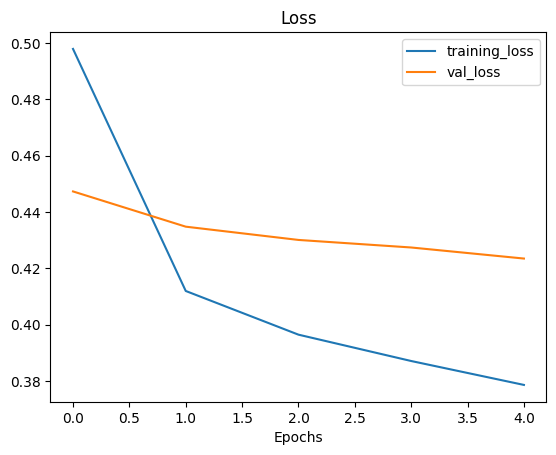

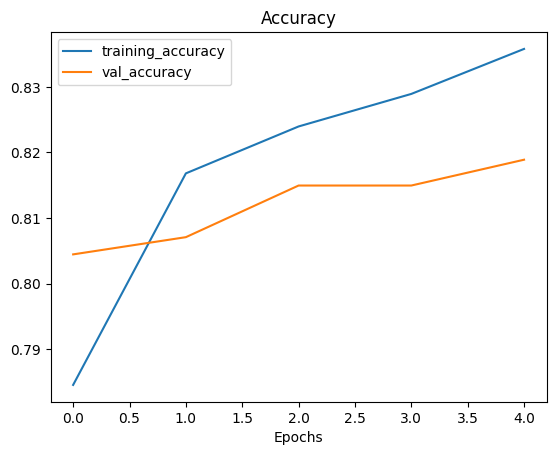

In [111]:
plot_loss_curves(history)

In [138]:
val_embeddings[:10]


array([[ 0.0253112 ,  0.05712115,  0.08734502, ..., -0.02358777,
        -0.06875653, -0.0138536 ],
       [-0.03017777,  0.04303274, -0.05815431, ..., -0.01380978,
        -0.05438795, -0.04689571],
       [-0.02031625,  0.02219867, -0.03273197, ...,  0.03510214,
         0.00280896, -0.07606301],
       ...,
       [-0.02756724, -0.04836835,  0.01859807, ..., -0.00083029,
        -0.0357345 , -0.07465898],
       [ 0.02946254,  0.03109458, -0.03109119, ..., -0.01025312,
        -0.06876561, -0.08181965],
       [-0.02331881,  0.04742435,  0.089688  , ..., -0.02005964,
         0.03122622,  0.00973427]], dtype=float32)

In [118]:
# model_6_pred_probs = model_6.predict(val_embeddings[0])
# model_6_pred_probs[]

In [119]:
train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)
train_10_percent.head(), len(train_10_percent)

(                                                   text  target
 4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
 584   FedEx no longer to transport bioterror germs i...       0
 7411  Gunmen kill four in El Salvador bus attack: Su...       1
 5950  @camilacabello97 Internally and externally scr...       1
 5541  Radiation emergency #preparedness starts with ...       1,
 761)

In [121]:
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
 'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
 'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
 '@camilacabello97 Internally and externally screaming',
 'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
 'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
 'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
 "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by S\x89Û_ http://t.co/JDVSGVhlIs",
 '\x89Û

In [126]:
!wandb sync /kaggle/working/model_logs
a0ac1d7bf9160805512283eb8f37ad7a757d8dd6

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [134]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=secret_value_0)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mogesastu2124 (moges-densatechnology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [136]:
!wandb sync /kaggle/working/model_logs


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Saving and loading a trained model
there are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The SavedModel format(this is the default when using TensorFlow)

In [147]:
model_6.save("models/model_6.h5")

In [148]:
model_5.save("models/model_5.keras")

In [159]:
#load model with custom Hub layer (required HDF5 format)
model_6_loaded = tf.keras.models.load_model("model_5.keras")

In [160]:
model_6_loaded.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,901,637 (14.88 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,601,092 (9.92 MB)

In [167]:
testing_sentences = val_sentences[:10]

In [168]:
model_6_loaded.predict(testing_sentences)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[7.1230042e-01],
       [9.7099811e-01],
       [9.9995768e-01],
       [1.1597184e-01],
       [1.0159571e-07],
       [9.9509960e-01],
       [9.9526656e-01],
       [9.9999356e-01],
       [1.0000000e+00],
       [9.8987204e-01]], dtype=float32)

## Finding the most wrong examples

In [172]:
import pandas as pd
val_df = pd.DataFrame({"text":val_sentences,
                      "target":val_labels,
                      "pred":model_5_preds}
    
)
val_df.head

<bound method NDFrame.head of                                                   text  target  pred
0    DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0   0.0
1    FedEx no longer to transport bioterror germs i...       0   1.0
2    Gunmen kill four in El Salvador bus attack: Su...       1   1.0
3    @camilacabello97 Internally and externally scr...       1   0.0
4    Radiation emergency #preparedness starts with ...       1   0.0
..                                                 ...     ...   ...
757            That's the ultimate road to destruction       0   0.0
758  @SetZorah dad why dont you claim me that mean ...       0   1.0
759  FedEx will no longer transport bioterror patho...       0   0.0
760  Crack in the path where I wiped out this morni...       0   0.0
761  I liked a @YouTube video from @dannyonpc http:...       0   0.0

[762 rows x 3 columns]>